In [1]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from matplotlib import pyplot as plt

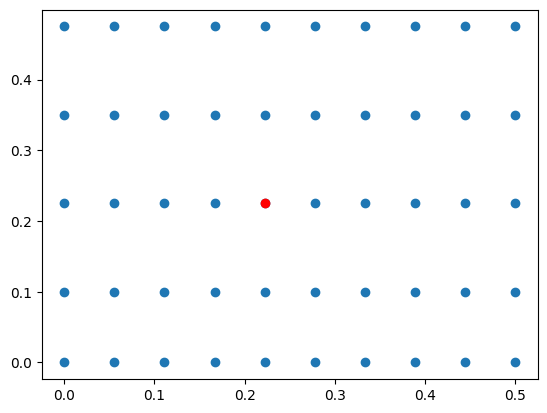

[10, 5] (50, 2)


In [41]:
nodes = 50

shape = []
loop_n = int(np.sqrt(nodes))
if loop_n**2 == nodes:
    shape = [loop_n, loop_n]
else:
    factor = []
    for i in range(1, nodes):
        if nodes % i == 0:
            factor.append(i)

    factor_ = np.flip(factor)
    for idx, f in enumerate(factor_):
        if idx+1 == len(factor_):
            continue
        next_ = factor_[idx+1]
        if f * next_ == nodes:
            shape = [f, next_]
            break

assert len(shape) == 2
km = 0.1 * shape[1]
center_x = np.ceil(shape[0] / 2)
center_y = np.ceil(shape[1] / 2)

grid = []
available_position = []
counter = 0
for row in range(1, shape[0] + 1):
    for col in range(1, shape[1] + 1):
        grid.append([row, col])
        counter += 1
        if row == center_x and col == center_y:
            continue
        available_position.append(counter)

grid = np.array(grid)
scaler = MinMaxScaler(feature_range=(0,km))
scaler.fit(grid)
grid_ = scaler.transform(grid)
[[center_x, center_y]] = scaler.transform([[center_x, center_y]])

# scale vertical size
next_ver = grid_[1]
next_hor = grid_[grid_.shape[1]]
ver_diff = next_ver[1]-grid_[0][1]
hor_diff = next_hor[0]-grid_[0][0]
if ver_diff > 0.1:
    num_diff = ver_diff-0.1
    grid_t = [[x[0], max(x[1]-num_diff, 0)] for x in grid_] 
    center_y = max(center_y-num_diff, 0)
    grid_ = np.array(grid_t)

x, y = grid_.T
plt.scatter(x,y)
plt.scatter(center_x,center_y,color='r')
plt.show()

print(shape, grid_.shape)

In [31]:
print(center_x, center_y)

0.10000000000000002 -0.15000000000000002


In [21]:
grid_

array([[0.  , 0.  ],
       [0.  , 0.2 ],
       [0.05, 0.  ],
       [0.05, 0.2 ],
       [0.1 , 0.  ],
       [0.1 , 0.2 ],
       [0.15, 0.  ],
       [0.15, 0.2 ],
       [0.2 , 0.  ],
       [0.2 , 0.2 ]])

In [6]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn as sns

sns.set()

#Fixing seed for reproducibility
np.random.seed(0)

In [7]:
#Loading and rendering the gym environment
env = gym.make("Taxi-v3")
env.reset()

n_observations = env.observation_space.n
n_actions = env.action_space.n

#Initialize the Q-table to 0
Q = np.zeros((n_observations,n_actions))
print(Q)

#Getting the state space
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Action Space Discrete(6)
State Space Discrete(500)


Training score over time: -1.976 7.74


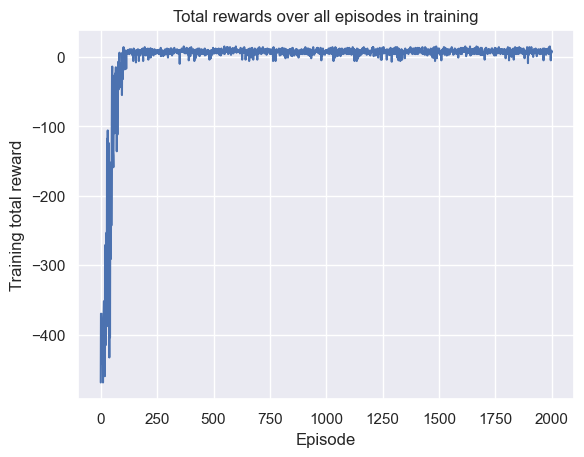

In [22]:
#Setting the hyperparameters

train_episodes = 2000   
max_steps = 100

alpha = 0.1 #learning rate                 
discount_factor = 0.9
# epsilon = 1                  
# max_epsilon = 1
# min_epsilon = 0.01         
# decay = 0.01

use_mine = True

if use_mine:
    # mine
    max_epsilon = 1
    min_epsilon = 0.01
    epsilon = max_epsilon
    decay = 0.01
    delta = (max_epsilon - min_epsilon) * decay


#Creating lists to keep track of reward and epsilon values
training_rewards = []  
epsilons = []
result_p = []
result_d = []
result_r = []

total_total_training_rewards = 0
prev_total_training_rewards = 0
for episode in range(train_episodes):
    #Reseting the environment each time as per requirement
    state, prob = env.reset()    
    #Starting the tracker for the rewards
    total_training_rewards = 0

    
    for step in range(max_steps):
        #Choosing an action given the states based on a random number
        exp_exp_tradeoff = random.uniform(0, 1) 
        
        
        ### STEP 2: SECOND option for choosing the initial action - exploit     
        #If the random number is larger than epsilon: employing exploitation 
        #and selecting best action 
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(Q[state,:])
            
        ### STEP 2: FIRST option for choosing the initial action - explore       
        #Otherwise, employing exploration: choosing a random action 
        else:
            action = env.action_space.sample()
            
            
        ### STEPs 3 & 4: performing the action and getting the reward     
        #Taking the action and getting the reward and outcome state
        val = env.step(action)
        new_state, reward, done, info, prob = val

        ### STEP 5: update the Q-table
        #Updating the Q-table using the Bellman equation
        Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * np.max(Q[new_state, :]) - Q[state, action]) 
        #Increasing our total reward and updating the state
        total_training_rewards += reward      
        state = new_state         
        
        #Ending the episode
        if done == True:
            #print ("Total reward for episode {}: {}".format(episode, total_training_rewards))
            break
    
    total_total_training_rewards += total_training_rewards

    if use_mine:

        p = total_total_training_rewards/(episode+1)
        diff = p

        new_epsilon = epsilon
        des = 1
        if episode > 0:
            prev_p = prev_total_training_rewards/(episode)
            diff = p - prev_p
            if diff > 0:
                des = 0
                # exploit
                new_epsilon -= delta
            else:
                # explore
                new_epsilon += delta
            result_p.append(p)
            result_d.append(des)


        new_epsilon = max(new_epsilon, min_epsilon)
        new_epsilon = min(new_epsilon, max_epsilon)
        epsilon = new_epsilon
    
    else:

        #Cutting down on exploration by reducing the epsilon 
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay*episode)
    
    #Adding the total reward and reduced epsilon values
    training_rewards.append(total_training_rewards)
    result_r.append(total_total_training_rewards/(episode+1))
    epsilons.append(epsilon)

    prev_total_training_rewards = total_total_training_rewards

print ("Training score over time: " + str(sum(training_rewards)/train_episodes), np.average(training_rewards[-100:]))

#Visualizing results and total reward over all episodes
x = range(train_episodes)
plt.plot(x, training_rewards)
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.show()

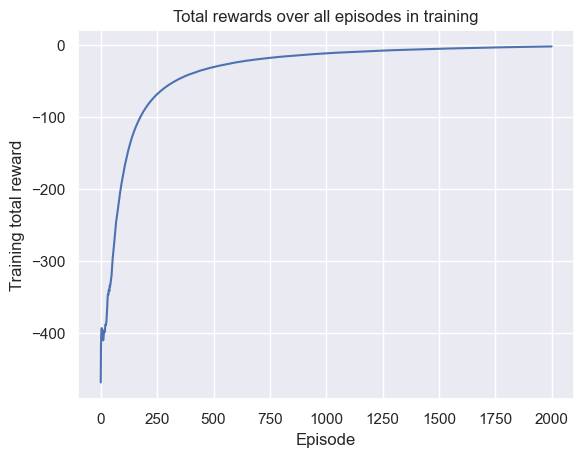

In [23]:
#Visualizing results and total reward over all episodes
x = range(train_episodes)
plt.plot(x, result_r)
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.show()

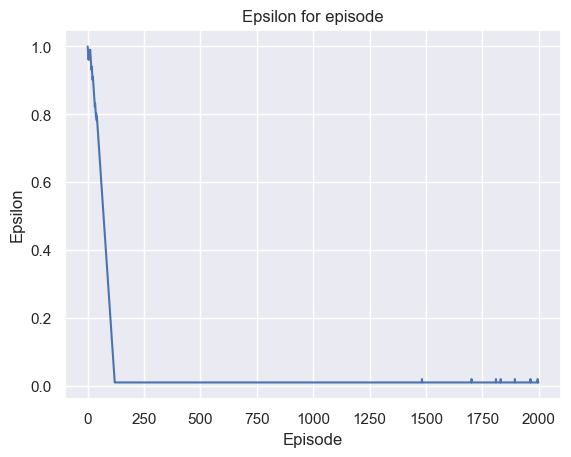

In [25]:
#Visualizing the epsilons over all episodes
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon for episode")
plt.show()

1000


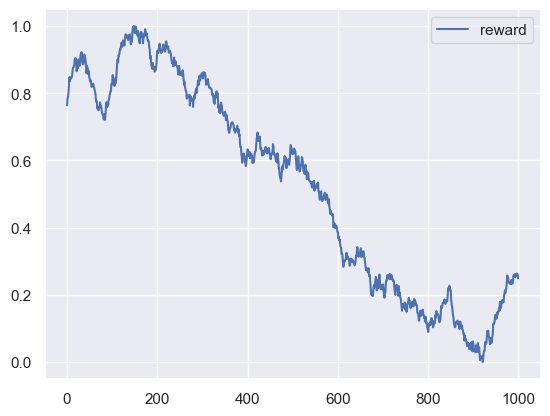

In [26]:
episodes = 1000
x = np.linspace(1, episodes, episodes)

def f(x):
    y = 0
    result = []
    for _ in x:
        result.append(y)
        y += np.random.normal(scale=1)
    return np.array(result)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

pfree_i = NormalizeData(f(x))
print(len(pfree_i))

# log scale plot
plt.plot(pfree_i, label ='reward')
plt.legend()
plt.show()

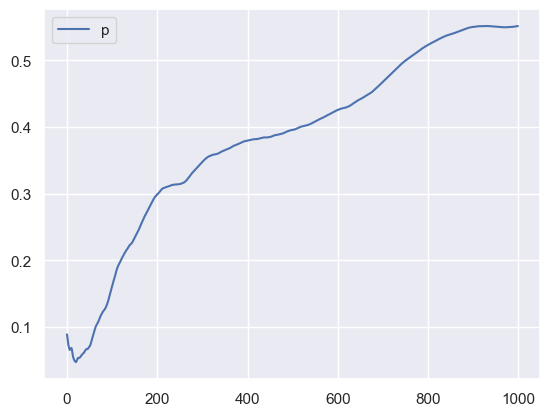

In [400]:
max_epsilon = 1
epsilon = max_epsilon
min_epsilon = 0.01
decay = 0.01
delta = (max_epsilon - min_epsilon) * decay

result_e = []
result_p = []

total_reward = 0
prev_total_reward = 0
for episode in range(episodes):
    
    reward = pfree_i[episode]
    total_reward += reward

    p = total_reward / (episode+1)
    new_epsilon = epsilon
    diff = p
    if episode > 0:
        prev_p = prev_total_reward / episode
        diff = p - prev_p
        if diff > 0:
            # exploit
            new_epsilon -= delta
        else:
            # explore
            new_epsilon += delta

    new_epsilon = max(new_epsilon, min_epsilon)
    new_epsilon = min(new_epsilon, max_epsilon)

    result_p.append(p)
    result_e.append(epsilon)

    epsilon = new_epsilon
    prev_total_reward = total_reward

# log scale plot
plt.plot(result_p, label ='p')
plt.legend()
plt.show()

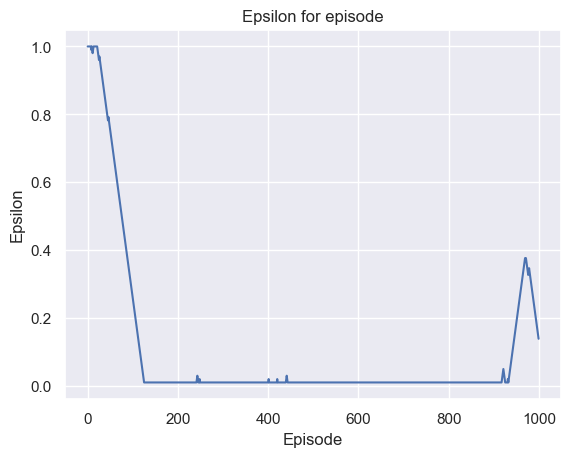

In [401]:
#Visualizing the epsilons over all episodes
plt.plot(result_e)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon for episode")
plt.show()

In [147]:
episode = 4

epsilon = max_epsilon
decay = 0.01
min_epsilon = 0.01
new_epsilon = max(min_epsilon, np.exp(-decay*episode))

print(epsilon, new_epsilon)

1 0.9607894391523232


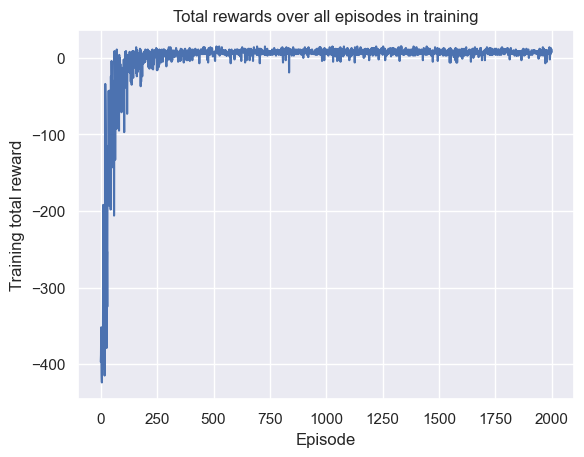

In [292]:
#Visualizing results and total reward over all episodes
x = range(train_episodes)
plt.plot(x, training_rewards)
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.show()

In [2]:
import random
import math

app_pkPeriod = 1
app_pkPeriodVar = 0.1
diff = (app_pkPeriod*app_pkPeriodVar)
min_ = int(math.ceil((app_pkPeriod - diff) * 1000))
max_ = int(math.ceil((app_pkPeriod + diff) * 1000))
delay = random.randint(min_, max_)
print(min_, max_, delay)

900 1100 955


In [8]:
a = [54, 0, 33, 4, 2, 0]
a.reverse()
a

[0, 2, 4, 33, 0, 54]

In [32]:
src = [2, 0]
(src[0] << 8) | src[1]

512

In [25]:
(4+6)/2

5.0

In [29]:
((4 - 6) / (1 + 1))

-1.0

In [28]:
inc_mean =  6 + ((4 - 6) / (1 + 1))
inc_mean

5.0

In [27]:
import numpy as np
a = list(range(10))
cur_mean = np.mean(a)
print(cur_mean)
new_val = 5
b = a + [new_val]
expected1 = np.mean(b)
print(expected1)

inc_mean =  cur_mean + ((new_val - cur_mean) / (len(a) + 1))
print(inc_mean)

4.5
4.545454545454546
4.545454545454546


In [28]:
new_val = 15
c = b + [new_val]
expected2 = np.mean(c)
print(expected2)

inc_mean2 =  expected1 + ((new_val - expected1) / (len(b) + 1))
print(inc_mean2)

5.416666666666667
5.416666666666667


In [24]:
imin = pow(2, 10)

imax = 20
for i in range(imax+1):
    cal = imin * pow(2, i) / 1000
    if cal > 60:
        cal /= 60
        print(i, round(cal, 5), 'm')
    else:
        print(i, int(cal), 's')
    

0 1 s
1 2 s
2 4 s
3 8 s
4 16 s
5 32 s
6 1.09227 m
7 2.18453 m
8 4.36907 m
9 8.73813 m
10 17.47627 m
11 34.95253 m
12 69.90507 m
13 139.81013 m
14 279.62027 m
15 559.24053 m
16 1118.48107 m
17 2236.96213 m
18 4473.92427 m
19 8947.84853 m
20 17895.69707 m


In [3]:
lds = [0.2, 0.5, 0.8]
eps = [0.001, 0.01, 0.1]

comb = {}
for ep in eps:
    for l in lds:
        for d in lds:
            t = "{} {} {}".format(ep, l, d)
            comb[t] = 0

print(comb.keys(), print(len(comb.keys())))


27
dict_keys(['0.001 0.2 0.2', '0.001 0.2 0.5', '0.001 0.2 0.8', '0.001 0.5 0.2', '0.001 0.5 0.5', '0.001 0.5 0.8', '0.001 0.8 0.2', '0.001 0.8 0.5', '0.001 0.8 0.8', '0.01 0.2 0.2', '0.01 0.2 0.5', '0.01 0.2 0.8', '0.01 0.5 0.2', '0.01 0.5 0.5', '0.01 0.5 0.8', '0.01 0.8 0.2', '0.01 0.8 0.5', '0.01 0.8 0.8', '0.1 0.2 0.2', '0.1 0.2 0.5', '0.1 0.2 0.8', '0.1 0.5 0.2', '0.1 0.5 0.5', '0.1 0.5 0.8', '0.1 0.8 0.2', '0.1 0.8 0.5', '0.1 0.8 0.8']) None


In [83]:
import pandas as pd 

df = pd.read_csv("simulator/bin/simData/comparison_merged.csv")
df

,parameter,method,last_DIOtransmit-mean,last_DIOtransmit-std,last_DIOsurpress-mean,last_DIOsurpress-std
0,"(10, 1)",ORI,262.000000,19.000000,0.666667,0.577350
1,"(10, 1)",RIATA,146.000000,36.510273,124.000000,15.620499
2,"(10, 1)",AC,196.333333,9.865766,43.000000,9.539392
3,"(10, 1)",QT,62.666667,30.924640,154.666667,2.081666
4,"(10, 10)",ORI,103.666667,22.300972,0.333333,0.577350
5,"(10, 10)",RIATA,71.333333,20.033306,64.666667,20.816660
6,"(10, 10)",AC,85.333333,6.658328,8.666667,2.516611
7,"(10, 10)",QT,51.000000,1.000000,69.333333,10.692677
8,"(10, 5)",ORI,131.333333,8.082904,0.333333,0.577350
9,"(10, 5)",RIATA,68.000000,9.165151,72.000000,9.000000


In [84]:
df_ = df.copy()
df_

,parameter,method,last_DIOtransmit-mean,last_DIOtransmit-std,last_DIOsurpress-mean,last_DIOsurpress-std
0,"(10, 1)",ORI,262.000000,19.000000,0.666667,0.577350
1,"(10, 1)",RIATA,146.000000,36.510273,124.000000,15.620499
2,"(10, 1)",AC,196.333333,9.865766,43.000000,9.539392
3,"(10, 1)",QT,62.666667,30.924640,154.666667,2.081666
4,"(10, 10)",ORI,103.666667,22.300972,0.333333,0.577350
5,"(10, 10)",RIATA,71.333333,20.033306,64.666667,20.816660
6,"(10, 10)",AC,85.333333,6.658328,8.666667,2.516611
7,"(10, 10)",QT,51.000000,1.000000,69.333333,10.692677
8,"(10, 5)",ORI,131.333333,8.082904,0.333333,0.577350
9,"(10, 5)",RIATA,68.000000,9.165151,72.000000,9.000000


In [88]:
df_t = df_.pivot(index='parameter', columns='method', values=df_.columns[2:].to_list())
df_t = df_t.reset_index()
df_t.columns = df_t.columns.map('-'.join)
df_t

,parameter-,last_DIOtransmit-mean-AC,last_DIOtransmit-mean-ORI,last_DIOtransmit-mean-QT,last_DIOtransmit-mean-RIATA,last_DIOtransmit-std-AC,last_DIOtransmit-std-ORI,last_DIOtransmit-std-QT,last_DIOtransmit-std-RIATA,last_DIOsurpress-mean-AC,last_DIOsurpress-mean-ORI,last_DIOsurpress-mean-QT,last_DIOsurpress-mean-RIATA,last_DIOsurpress-std-AC,last_DIOsurpress-std-ORI,last_DIOsurpress-std-QT,last_DIOsurpress-std-RIATA
0,"(10, 1)",196.333333,262.000000,62.666667,146.000000,9.865766,19.000000,30.924640,36.510273,43.000000,0.666667,154.666667,124.000000,9.539392,0.577350,2.081666,15.620499
1,"(10, 10)",85.333333,103.666667,51.000000,71.333333,6.658328,22.300972,1.000000,20.033306,8.666667,0.333333,69.333333,64.666667,2.516611,0.577350,10.692677,20.816660
2,"(10, 5)",117.333333,131.333333,72.000000,68.000000,8.504901,8.082904,9.848858,9.165151,10.333333,0.333333,105.000000,72.000000,2.309401,0.577350,12.529964,9.000000
3,"(100, 1)",1864.333333,2955.333333,1331.666667,1678.000000,59.702038,15.044379,127.884062,136.495421,532.333333,44.333333,1715.666667,1428.666667,14.364308,4.932883,87.076595,125.049324
4,"(100, 10)",1119.666667,1602.333333,835.000000,970.333333,43.038742,203.591093,67.579583,39.272552,104.333333,20.666667,761.333333,729.000000,8.962886,3.511885,30.022214,11.532563
5,"(100, 5)",1352.333333,1850.333333,896.666667,1136.333333,105.191888,232.295788,84.512327,66.665833,119.333333,23.666667,1011.000000,899.333333,10.016653,6.429101,92.081486,39.576929
6,"(50, 1)",922.666667,1411.333333,552.333333,826.000000,100.380941,66.123622,80.313967,24.248711,226.000000,6.000000,847.666667,712.666667,4.582576,1.000000,38.004386,17.897858
7,"(50, 10)",531.333333,658.666667,475.666667,426.666667,11.372481,143.966431,42.193996,15.275252,52.000000,5.000000,259.666667,348.666667,3.605551,2.000000,29.501412,28.919428
8,"(50, 5)",645.666667,842.333333,376.666667,496.000000,1.527525,72.196491,21.594752,22.715633,55.666667,10.000000,448.666667,467.666667,5.131601,4.582576,15.534907,34.645827


In [89]:
df_t.to_csv('dio-transmission.csv', index=False)

In [90]:
a = "BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB"
len(a)

40

In [2]:
import pandas as pd

df = pd.read_csv("convergence_test.csv")
df

,state,DIOsurpress,DIOtransmit,epsilon,k,listen_period_ms,listen_period_s,pfree
0,1,1,0,1.000,1,1048.074785,1.048075,0.333333
1,2,1,1,0.802,3,4476.399729,4.476400,0.600000
2,3,1,2,0.604,4,5788.592058,5.788592,0.714286
3,4,1,3,0.406,4,1589.226230,1.589226,0.727273
4,5,1,4,0.208,3,1346.319777,1.346320,1.000000
5,6,1,5,0.010,3,3898.039770,3.898040,1.000000
6,7,1,6,0.010,3,7506.935899,7.506936,0.875000
7,8,1,7,0.010,3,15183.222970,15.183223,0.882353
8,9,1,8,0.010,3,1232.866989,1.232867,0.666667
9,10,1,9,0.010,3,1154.475948,1.154476,0.833333


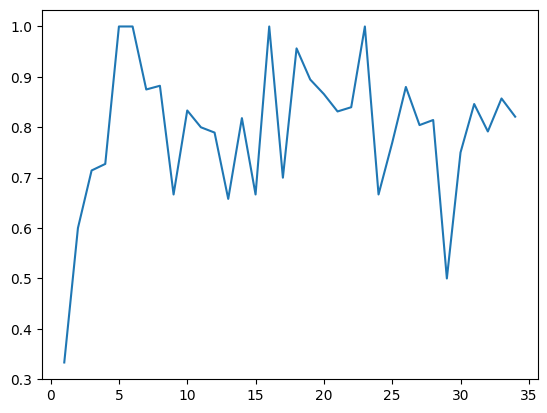

In [17]:
import matplotlib.pyplot as plt
import numpy as np

x, y = df[['state', 'pfree']].values.T


plt.plot(x,y)

In [47]:
N = 6
np.ones((N,))/N

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

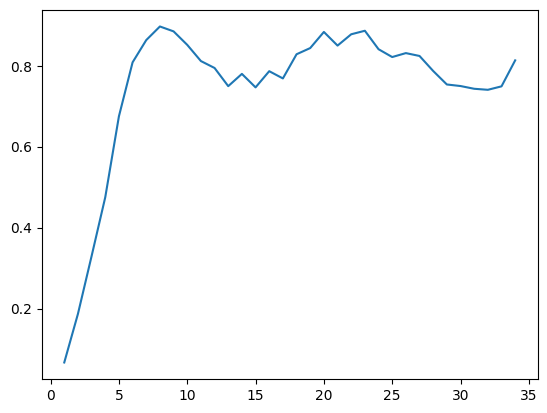

In [50]:
def runningMean(x, N):
    filter = np.ones((N,))/N
    return np.convolve(x, filter)[:len(x)]

y_ = runningMean(y, 5)

plt.plot(x, y_)

In [90]:
test =  {
                "1": {
                    "DIOsurpress": 0,
                    "DIOtransmit": 1,
                    "DIOtransmit_collision": 0,
                    "Ncells": 3,
                    "Nreset": 0,
                    "average_reward": 0.6666666666666667,
                    "counter": 0,
                    "end_t_record": 6,
                    "epsilon": 1,
                    "epsilon_exploit": 0,
                    "epsilon_explore": 0,
                    "interval": 5.0,
                    "is_dio_truly_sent": 1,
                    "k": 2,
                    "listen_period": 0.28191206113140715,
                    "m": 0,
                    "pfree": 0.6666666666666667,
                    "poccupancy": 0.3333333333333333,
                    "preset": 0.0,
                    "pstable": 1.0,
                    "start_t_record": 5,
                    "state": 1,
                    "t": 5.6382412226281434e-05,
                    "t_end": 0.0005,
                    "t_start": 0.0,
                    "used": 1
                },
                "2": {
                    "DIOsurpress": 1,
                    "DIOtransmit": 1,
                    "DIOtransmit_collision": 0,
                    "Ncells": 7,
                    "Nreset": 0,
                    "average_reward": 0.761904761904762,
                    "counter": 1,
                    "end_t_record": 11,
                    "epsilon": 0.9505,
                    "epsilon_exploit": 1,
                    "epsilon_explore": 0,
                    "interval": 10.0,
                    "is_dio_truly_sent": 0,
                    "k": 1,
                    "listen_period": 5.144016629860527,
                    "m": 1,
                    "pfree": 0.8571428571428572,
                    "poccupancy": 0.14285714285714285,
                    "preset": 0.0,
                    "pstable": 1.0,
                    "start_t_record": 10,
                    "state": 2,
                    "t": 0.0008477349963193861,
                    "t_end": 0.001,
                    "t_start": 0.0003333333333333334,
                    "used": 1
                },
                "3": {
                    "DIOsurpress": 1,
                    "DIOtransmit": 2,
                    "DIOtransmit_collision": 0,
                    "Ncells": 16,
                    "Nreset": 0,
                    "average_reward": 0.7371031746031745,
                    "counter": 1,
                    "end_t_record": 16,
                    "epsilon": 1.0,
                    "epsilon_exploit": 1,
                    "epsilon_explore": 1,
                    "interval": 20.0,
                    "is_dio_truly_sent": 1,
                    "k": 1,
                    "listen_period": 0.5840910628131123,
                    "m": 2,
                    "pfree": 0.6875,
                    "poccupancy": 0.3125,
                    "preset": 0.0,
                    "pstable": 1.0,
                    "start_t_record": 11,
                    "state": 3,
                    "t": 0.0002434902674263699,
                    "t_end": 0.001,
                    "t_start": 0.0002142857142857143,
                    "used": 5
                },
                "4": {
                    "DIOsurpress": 1,
                    "DIOtransmit": 3,
                    "DIOtransmit_collision": 0,
                    "Ncells": 31,
                    "Nreset": 0,
                    "average_reward": 0.7302467357910907,
                    "counter": 0,
                    "end_t_record": 26,
                    "epsilon": 1,
                    "epsilon_exploit": 1,
                    "epsilon_explore": 2,
                    "interval": 40.0,
                    "is_dio_truly_sent": 1,
                    "k": 1,
                    "listen_period": 9.094212337290644,
                    "m": 3,
                    "pfree": 0.7096774193548387,
                    "poccupancy": 0.2903225806451613,
                    "preset": 0.0,
                    "pstable": 1.0,
                    "start_t_record": 17,
                    "state": 4,
                    "t": 0.0004565219750989328,
                    "t_end": 0.001,
                    "t_start": 0.00022916666666666666,
                    "used": 9
                },
                "5": {
                    "DIOsurpress": 1,
                    "DIOtransmit": 4,
                    "DIOtransmit_collision": 0,
                    "Ncells": 4,
                    "Nreset": 1,
                    "average_reward": 0.6341973886328726,
                    "counter": 1,
                    "end_t_record": 32,
                    "epsilon": 1,
                    "epsilon_exploit": 1,
                    "epsilon_explore": 3,
                    "interval": 5.0,
                    "is_dio_truly_sent": 1,
                    "k": 2,
                    "listen_period": 1.8196946563491239,
                    "m": 0,
                    "pfree": 0.25,
                    "poccupancy": 0.75,
                    "preset": 0.2,
                    "pstable": 0.8,
                    "start_t_record": 29,
                    "state": 5,
                    "t": 0.0006300679635278893,
                    "t_end": 0.0009,
                    "t_start": 0.0002661290322580645,
                    "used": 3
                },
                "6": {
                    "DIOsurpress": 1,
                    "DIOtransmit": 5,
                    "DIOtransmit_collision": 0,
                    "Ncells": 8,
                    "Nreset": 1,
                    "average_reward": 0.6326644905273938,
                    "counter": 1,
                    "end_t_record": 35,
                    "epsilon": 1,
                    "epsilon_exploit": 1,
                    "epsilon_explore": 4,
                    "interval": 10.0,
                    "is_dio_truly_sent": 1,
                    "k": 2,
                    "listen_period": 4.122601070422631,
                    "m": 1,
                    "pfree": 0.625,
                    "poccupancy": 0.375,
                    "preset": 0.16666666666666666,
                    "pstable": 0.8333333333333334,
                    "start_t_record": 32,
                    "state": 6,
                    "t": 0.0005122601070422631,
                    "t_end": 0.0009,
                    "t_start": 0.0001,
                    "used": 3
                },
                "7": {
                    "DIOsurpress": 1,
                    "DIOtransmit": 6,
                    "DIOtransmit_collision": 0,
                    "Ncells": 13,
                    "Nreset": 1,
                    "average_reward": 0.6411849479245794,
                    "counter": 0,
                    "end_t_record": 40,
                    "epsilon": 0.9505,
                    "epsilon_exploit": 2,
                    "epsilon_explore": 4,
                    "interval": 20.0,
                    "is_dio_truly_sent": 1,
                    "k": 2,
                    "listen_period": 9.582852524436435,
                    "m": 2,
                    "pfree": 0.6923076923076923,
                    "poccupancy": 0.3076923076923077,
                    "preset": 0.14285714285714285,
                    "pstable": 0.8571428571428572,
                    "start_t_record": 36,
                    "state": 7,
                    "t": 0.0007395592928884884,
                    "t_end": 0.0009166666666666668,
                    "t_start": 0.00026041666666666666,
                    "used": 4
                },
                "8": {
                    "DIOsurpress": 1,
                    "DIOtransmit": 7,
                    "DIOtransmit_collision": 0,
                    "Ncells": 26,
                    "Nreset": 1,
                    "average_reward": 0.6523829832801608,
                    "counter": 1,
                    "end_t_record": 51,
                    "epsilon": 0.901,
                    "epsilon_exploit": 3,
                    "epsilon_explore": 4,
                    "interval": 40.0,
                    "is_dio_truly_sent": 1,
                    "k": 2,
                    "listen_period": 19.886375799314635,
                    "m": 3,
                    "pfree": 0.7307692307692308,
                    "poccupancy": 0.2692307692307692,
                    "preset": 0.125,
                    "pstable": 0.875,
                    "start_t_record": 44,
                    "state": 8,
                    "t": 0.0007938626916861626,
                    "t_end": 0.0009285714285714286,
                    "t_start": 0.0002967032967032967,
                    "used": 7
                },
                "9": {
                    "DIOsurpress": 1,
                    "DIOtransmit": 8,
                    "DIOtransmit_collision": 0,
                    "Ncells": 49,
                    "Nreset": 1,
                    "average_reward": 0.6660637855914354,
                    "counter": 1,
                    "end_t_record": 65,
                    "epsilon": 0.8515,
                    "epsilon_exploit": 4,
                    "epsilon_explore": 4,
                    "interval": 80.0,
                    "is_dio_truly_sent": 1,
                    "k": 2,
                    "listen_period": 18.26713652854642,
                    "m": 4,
                    "pfree": 0.7755102040816326,
                    "poccupancy": 0.22448979591836735,
                    "preset": 0.1111111111111111,
                    "pstable": 0.8888888888888888,
                    "start_t_record": 54,
                    "state": 9,
                    "t": 0.0005480507450683687,
                    "t_end": 0.0009375,
                    "t_start": 0.0003197115384615385,
                    "used": 11
                },
                "10": {
                    "DIOsurpress": 1,
                    "DIOtransmit": 9,
                    "DIOtransmit_collision": 1,
                    "Ncells": 3,
                    "Nreset": 2,
                    "average_reward": 0.6661240736989587,
                    "counter": 1,
                    "end_t_record": 71,
                    "epsilon": 0.802,
                    "epsilon_exploit": 5,
                    "epsilon_explore": 4,
                    "interval": 5.0,
                    "is_dio_truly_sent": 0,
                    "k": 2,
                    "listen_period": 2.4398026023150328,
                    "m": 0,
                    "pfree": 0.6666666666666667,
                    "poccupancy": 0.3333333333333333,
                    "preset": 0.2,
                    "pstable": 0.8,
                    "start_t_record": 70,
                    "state": 10,
                    "t": 0.0008326317222770655,
                    "t_end": 0.0009,
                    "t_start": 0.0003446712018140589,
                    "used": 1
                },
                "11": {
                    "DIOsurpress": 1,
                    "DIOtransmit": 10,
                    "DIOtransmit_collision": 1,
                    "Ncells": 6,
                    "Nreset": 2,
                    "average_reward": 0.6661734003323866,
                    "counter": 0,
                    "end_t_record": 74,
                    "epsilon": 0.7525000000000001,
                    "epsilon_exploit": 6,
                    "epsilon_explore": 4,
                    "interval": 10.0,
                    "is_dio_truly_sent": 1,
                    "k": 2,
                    "listen_period": 1.7513854837542127,
                    "m": 1,
                    "pfree": 0.6666666666666667,
                    "poccupancy": 0.3333333333333333,
                    "preset": 0.18181818181818182,
                    "pstable": 0.8181818181818181,
                    "start_t_record": 72,
                    "state": 11,
                    "t": 0.0004751385483754213,
                    "t_end": 0.0009,
                    "t_start": 0.00030000000000000003,
                    "used": 2
                },
                "12": {
                    "DIOsurpress": 1,
                    "DIOtransmit": 11,
                    "DIOtransmit_collision": 1,
                    "Ncells": 13,
                    "Nreset": 2,
                    "average_reward": 0.6811717708175083,
                    "counter": 1,
                    "end_t_record": 78,
                    "epsilon": 0.7030000000000001,
                    "epsilon_exploit": 7,
                    "epsilon_explore": 4,
                    "interval": 20.0,
                    "is_dio_truly_sent": 1,
                    "k": 2,
                    "listen_period": 3.112639350693743,
                    "m": 2,
                    "pfree": 0.8461538461538461,
                    "poccupancy": 0.15384615384615385,
                    "preset": 0.16666666666666666,
                    "pstable": 0.8333333333333334,
                    "start_t_record": 76,
                    "state": 12,
                    "t": 0.0004586622705649902,
                    "t_end": 0.0009090909090909091,
                    "t_start": 0.00030303030303030303,
                    "used": 2
                },
                "13": {
                    "DIOsurpress": 1,
                    "DIOtransmit": 12,
                    "DIOtransmit_collision": 1,
                    "Ncells": 21,
                    "Nreset": 2,
                    "average_reward": 0.6800559935751358,
                    "counter": 0,
                    "end_t_record": 87,
                    "epsilon": 0.7525000000000001,
                    "epsilon_exploit": 7,
                    "epsilon_explore": 5,
                    "interval": 40.0,
                    "is_dio_truly_sent": 1,
                    "k": 2,
                    "listen_period": 0.954191244434529,
                    "m": 3,
                    "pfree": 0.6666666666666667,
                    "poccupancy": 0.3333333333333333,
                    "preset": 0.15384615384615385,
                    "pstable": 0.8461538461538461,
                    "start_t_record": 80,
                    "state": 13,
                    "t": 0.00041167529393137606,
                    "t_end": 0.0009166666666666668,
                    "t_start": 0.00038782051282051276,
                    "used": 7
                },
                "14": {
                    "DIOsurpress": 1,
                    "DIOtransmit": 13,
                    "DIOtransmit_collision": 1,
                    "Ncells": 49,
                    "Nreset": 2,
                    "average_reward": 0.676670069835804,
                    "counter": 3,
                    "end_t_record": 112,
                    "epsilon": 0.802,
                    "epsilon_exploit": 7,
                    "epsilon_explore": 6,
                    "interval": 80.0,
                    "is_dio_truly_sent": 1,
                    "k": 2,
                    "listen_period": 8.506851695485874,
                    "m": 4,
                    "pfree": 0.6326530612244898,
                    "poccupancy": 0.3673469387755102,
                    "preset": 0.14285714285714285,
                    "pstable": 0.8571428571428572,
                    "start_t_record": 94,
                    "state": 14,
                    "t": 0.0004140279538858812,
                    "t_end": 0.0009230769230769231,
                    "t_start": 0.00030769230769230776,
                    "used": 18
                },
                "15": {
                    "DIOsurpress": 2,
                    "DIOtransmit": 13,
                    "DIOtransmit_collision": 1,
                    "Ncells": 101,
                    "Nreset": 2,
                    "average_reward": 0.6843640123748033,
                    "counter": 3,
                    "end_t_record": 152,
                    "epsilon": 0.7525000000000001,
                    "epsilon_exploit": 8,
                    "epsilon_explore": 6,
                    "interval": 160.0,
                    "is_dio_truly_sent": 0,
                    "k": 2,
                    "listen_period": 3.6498280666960854,
                    "m": 5,
                    "pfree": 0.7920792079207921,
                    "poccupancy": 0.2079207920792079,
                    "preset": 0.13333333333333333,
                    "pstable": 0.8666666666666667,
                    "start_t_record": 131,
                    "state": 15,
                    "t": 0.00031654320384250654,
                    "t_end": 0.0009285714285714286,
                    "t_start": 0.000293731778425656,
                    "used": 21
                },
                "16": {
                    "DIOsurpress": 3,
                    "DIOtransmit": 13,
                    "DIOtransmit_collision": 1,
                    "Ncells": 187,
                    "Nreset": 2,
                    "average_reward": 0.6923934006388112,
                    "counter": 10,
                    "end_t_record": 216,
                    "epsilon": 0.7030000000000001,
                    "epsilon_exploit": 9,
                    "epsilon_explore": 6,
                    "interval": 320.0,
                    "is_dio_truly_sent": 0,
                    "k": 2,
                    "listen_period": 188.79940375147837,
                    "m": 6,
                    "pfree": 0.8128342245989305,
                    "poccupancy": 0.18716577540106952,
                    "preset": 0.125,
                    "pstable": 0.875,
                    "start_t_record": 181,
                    "state": 16,
                    "t": 0.0009332324601557131,
                    "t_end": 0.0009333333333333332,
                    "t_start": 0.0003432343234323433,
                    "used": 35
                },
                "17": {
                    "DIOsurpress": 3,
                    "DIOtransmit": 14,
                    "DIOtransmit_collision": 2,
                    "Ncells": 3,
                    "Nreset": 3,
                    "average_reward": 0.690880063346332,
                    "counter": 0,
                    "end_t_record": 248,
                    "epsilon": 0.7525000000000001,
                    "epsilon_exploit": 9,
                    "epsilon_explore": 7,
                    "interval": 5.0,
                    "is_dio_truly_sent": 0,
                    "k": 3,
                    "listen_period": 2.4722712834265232,
                    "m": 0,
                    "pfree": 0.6666666666666667,
                    "poccupancy": 0.3333333333333333,
                    "preset": 0.17647058823529413,
                    "pstable": 0.8235294117647058,
                    "start_t_record": 247,
                    "state": 17,
                    "t": 0.0008246681604286201,
                    "t_end": 0.0009117647058823528,
                    "t_start": 0.00033021390374331547,
                    "used": 1
                },
                "18": {
                    "DIOsurpress": 3,
                    "DIOtransmit": 15,
                    "DIOtransmit_collision": 2,
                    "Ncells": 7,
                    "Nreset": 3,
                    "average_reward": 0.6921803772874088,
                    "counter": 0,
                    "end_t_record": 251,
                    "epsilon": 0.7030000000000001,
                    "epsilon_exploit": 10,
                    "epsilon_explore": 7,
                    "interval": 10.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 3.6533664341858145,
                    "m": 1,
                    "pfree": 0.7142857142857143,
                    "poccupancy": 0.2857142857142857,
                    "preset": 0.16666666666666666,
                    "pstable": 0.8333333333333334,
                    "start_t_record": 249,
                    "state": 18,
                    "t": 0.0006398464473401501,
                    "t_end": 0.0009117647058823528,
                    "t_start": 0.0002745098039215687,
                    "used": 2
                },
                "19": {
                    "DIOsurpress": 3,
                    "DIOtransmit": 16,
                    "DIOtransmit_collision": 2,
                    "Ncells": 13,
                    "Nreset": 3,
                    "average_reward": 0.6881384950819985,
                    "counter": 1,
                    "end_t_record": 259,
                    "epsilon": 0.7525000000000001,
                    "epsilon_exploit": 10,
                    "epsilon_explore": 8,
                    "interval": 20.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 11.016890027397256,
                    "m": 2,
                    "pfree": 0.6153846153846154,
                    "poccupancy": 0.38461538461538464,
                    "preset": 0.15789473684210525,
                    "pstable": 0.8421052631578947,
                    "start_t_record": 254,
                    "state": 19,
                    "t": 0.0008484635489889104,
                    "t_end": 0.0009166666666666668,
                    "t_start": 0.0002976190476190476,
                    "used": 5
                },
                "20": {
                    "DIOsurpress": 3,
                    "DIOtransmit": 17,
                    "DIOtransmit_collision": 2,
                    "Ncells": 27,
                    "Nreset": 3,
                    "average_reward": 0.6963241629204913,
                    "counter": 0,
                    "end_t_record": 264,
                    "epsilon": 0.7030000000000001,
                    "epsilon_exploit": 11,
                    "epsilon_explore": 8,
                    "interval": 40.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 23.473735430874257,
                    "m": 3,
                    "pfree": 0.8518518518518519,
                    "poccupancy": 0.14814814814814814,
                    "preset": 0.15,
                    "pstable": 0.85,
                    "start_t_record": 260,
                    "state": 20,
                    "t": 0.0008459526975127472,
                    "t_end": 0.0009210526315789473,
                    "t_start": 0.0002591093117408907,
                    "used": 4
                },
                "21": {
                    "DIOsurpress": 3,
                    "DIOtransmit": 18,
                    "DIOtransmit_collision": 2,
                    "Ncells": 3,
                    "Nreset": 4,
                    "average_reward": 0.6949119011941186,
                    "counter": 0,
                    "end_t_record": 269,
                    "epsilon": 0.7525000000000001,
                    "epsilon_exploit": 11,
                    "epsilon_explore": 9,
                    "interval": 5.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 2.1292501179586325,
                    "m": 0,
                    "pfree": 0.6666666666666667,
                    "poccupancy": 0.3333333333333333,
                    "preset": 0.19047619047619047,
                    "pstable": 0.8095238095238095,
                    "start_t_record": 268,
                    "state": 21,
                    "t": 0.0007878870606287635,
                    "t_end": 0.0009047619047619047,
                    "t_start": 0.00036203703703703707,
                    "used": 1
                },
                "22": {
                    "DIOsurpress": 3,
                    "DIOtransmit": 19,
                    "DIOtransmit_collision": 2,
                    "Ncells": 7,
                    "Nreset": 4,
                    "average_reward": 0.7022860355554249,
                    "counter": 0,
                    "end_t_record": 270,
                    "epsilon": 0.7030000000000001,
                    "epsilon_exploit": 12,
                    "epsilon_explore": 9,
                    "interval": 10.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 5.638700006249417,
                    "m": 1,
                    "pfree": 0.8571428571428572,
                    "poccupancy": 0.14285714285714285,
                    "preset": 0.18181818181818182,
                    "pstable": 0.8181818181818181,
                    "start_t_record": 269,
                    "state": 22,
                    "t": 0.0008495842863392274,
                    "t_end": 0.0009047619047619047,
                    "t_start": 0.00028571428571428574,
                    "used": 1
                },
                "23": {
                    "DIOsurpress": 3,
                    "DIOtransmit": 20,
                    "DIOtransmit_collision": 2,
                    "Ncells": 11,
                    "Nreset": 4,
                    "average_reward": 0.7033724134561773,
                    "counter": 1,
                    "end_t_record": 275,
                    "epsilon": 0.6535000000000001,
                    "epsilon_exploit": 13,
                    "epsilon_explore": 9,
                    "interval": 20.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 0.5231565363405425,
                    "m": 2,
                    "pfree": 0.7272727272727273,
                    "poccupancy": 0.2727272727272727,
                    "preset": 0.17391304347826086,
                    "pstable": 0.8260869565217391,
                    "start_t_record": 272,
                    "state": 23,
                    "t": 0.00039628769694689727,
                    "t_end": 0.0009090909090909091,
                    "t_start": 0.00037012987012987014,
                    "used": 3
                },
                "24": {
                    "DIOsurpress": 3,
                    "DIOtransmit": 21,
                    "DIOtransmit_collision": 2,
                    "Ncells": 24,
                    "Nreset": 4,
                    "average_reward": 0.7122596740066144,
                    "counter": 1,
                    "end_t_record": 280,
                    "epsilon": 0.6040000000000001,
                    "epsilon_exploit": 14,
                    "epsilon_explore": 9,
                    "interval": 40.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 9.352195361690764,
                    "m": 3,
                    "pfree": 0.9166666666666666,
                    "poccupancy": 0.08333333333333333,
                    "preset": 0.16666666666666666,
                    "pstable": 0.8333333333333334,
                    "start_t_record": 278,
                    "state": 24,
                    "t": 0.0005500104176391071,
                    "t_end": 0.0009130434782608696,
                    "t_start": 0.00031620553359683795,
                    "used": 2
                },
                "25": {
                    "DIOsurpress": 3,
                    "DIOtransmit": 22,
                    "DIOtransmit_collision": 2,
                    "Ncells": 41,
                    "Nreset": 4,
                    "average_reward": 0.7169400187536668,
                    "counter": 1,
                    "end_t_record": 291,
                    "epsilon": 0.5545000000000001,
                    "epsilon_exploit": 15,
                    "epsilon_explore": 9,
                    "interval": 80.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 38.98342536967379,
                    "m": 4,
                    "pfree": 0.8292682926829268,
                    "poccupancy": 0.17073170731707318,
                    "preset": 0.16,
                    "pstable": 0.84,
                    "start_t_record": 284,
                    "state": 25,
                    "t": 0.0008883344837875889,
                    "t_end": 0.0009166666666666668,
                    "t_start": 0.0004010416666666666,
                    "used": 7
                },
                "26": {
                    "DIOsurpress": 4,
                    "DIOtransmit": 22,
                    "DIOtransmit_collision": 2,
                    "Ncells": 88,
                    "Nreset": 4,
                    "average_reward": 0.7212709970533508,
                    "counter": 0,
                    "end_t_record": 313,
                    "epsilon": 0.5050000000000001,
                    "epsilon_exploit": 16,
                    "epsilon_explore": 9,
                    "interval": 160.0,
                    "is_dio_truly_sent": 0,
                    "k": 3,
                    "listen_period": 14.379314347559143,
                    "m": 5,
                    "pfree": 0.8295454545454546,
                    "poccupancy": 0.17045454545454544,
                    "preset": 0.15384615384615385,
                    "pstable": 0.8461538461538461,
                    "start_t_record": 298,
                    "state": 26,
                    "t": 0.0004547487634527324,
                    "t_end": 0.00092,
                    "t_start": 0.0003648780487804878,
                    "used": 15
                },
                "27": {
                    "DIOsurpress": 4,
                    "DIOtransmit": 23,
                    "DIOtransmit_collision": 2,
                    "Ncells": 3,
                    "Nreset": 5,
                    "average_reward": 0.7192486144464367,
                    "counter": 0,
                    "end_t_record": 326,
                    "epsilon": 0.5545000000000001,
                    "epsilon_exploit": 16,
                    "epsilon_explore": 10,
                    "interval": 5.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 2.051846844440941,
                    "m": 0,
                    "pfree": 0.6666666666666667,
                    "poccupancy": 0.3333333333333333,
                    "preset": 0.18518518518518517,
                    "pstable": 0.8148148148148149,
                    "start_t_record": 325,
                    "state": 27,
                    "t": 0.0007613309073497267,
                    "t_end": 0.0009074074074074074,
                    "t_start": 0.0003509615384615385,
                    "used": 1
                },
                "28": {
                    "DIOsurpress": 4,
                    "DIOtransmit": 24,
                    "DIOtransmit_collision": 2,
                    "Ncells": 7,
                    "Nreset": 5,
                    "average_reward": 0.7190713680121252,
                    "counter": 1,
                    "end_t_record": 328,
                    "epsilon": 0.6040000000000001,
                    "epsilon_exploit": 16,
                    "epsilon_explore": 11,
                    "interval": 10.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 2.8071592492452675,
                    "m": 1,
                    "pfree": 0.7142857142857143,
                    "poccupancy": 0.2857142857142857,
                    "preset": 0.17857142857142858,
                    "pstable": 0.8214285714285714,
                    "start_t_record": 326,
                    "state": 28,
                    "t": 0.0005646665422084775,
                    "t_end": 0.0009074074074074074,
                    "t_start": 0.00028395061728395067,
                    "used": 2
                },
                "29": {
                    "DIOsurpress": 4,
                    "DIOtransmit": 25,
                    "DIOtransmit_collision": 2,
                    "Ncells": 12,
                    "Nreset": 5,
                    "average_reward": 0.7172643093450405,
                    "counter": 0,
                    "end_t_record": 332,
                    "epsilon": 0.6535000000000001,
                    "epsilon_exploit": 16,
                    "epsilon_explore": 12,
                    "interval": 20.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 5.802739849327093,
                    "m": 2,
                    "pfree": 0.6666666666666667,
                    "poccupancy": 0.3333333333333333,
                    "preset": 0.1724137931034483,
                    "pstable": 0.8275862068965517,
                    "start_t_record": 328,
                    "state": 29,
                    "t": 0.0005962594414459466,
                    "t_end": 0.0009107142857142857,
                    "t_start": 0.0003061224489795918,
                    "used": 4
                },
                "30": {
                    "DIOsurpress": 4,
                    "DIOtransmit": 26,
                    "DIOtransmit_collision": 2,
                    "Ncells": 25,
                    "Nreset": 5,
                    "average_reward": 0.7213554990335391,
                    "counter": 0,
                    "end_t_record": 338,
                    "epsilon": 0.6040000000000001,
                    "epsilon_exploit": 17,
                    "epsilon_explore": 12,
                    "interval": 40.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 6.070086369233339,
                    "m": 3,
                    "pfree": 0.84,
                    "poccupancy": 0.16,
                    "preset": 0.16666666666666666,
                    "pstable": 0.8333333333333334,
                    "start_t_record": 334,
                    "state": 30,
                    "t": 0.00043910848106991395,
                    "t_end": 0.0009137931034482756,
                    "t_start": 0.0002873563218390805,
                    "used": 4
                },
                "31": {
                    "DIOsurpress": 4,
                    "DIOtransmit": 27,
                    "DIOtransmit_collision": 2,
                    "Ncells": 44,
                    "Nreset": 5,
                    "average_reward": 0.7237457908535716,
                    "counter": 0,
                    "end_t_record": 354,
                    "epsilon": 0.5545000000000001,
                    "epsilon_exploit": 18,
                    "epsilon_explore": 12,
                    "interval": 80.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 3.931030591431307,
                    "m": 4,
                    "pfree": 0.7954545454545454,
                    "poccupancy": 0.20454545454545456,
                    "preset": 0.16129032258064516,
                    "pstable": 0.8387096774193549,
                    "start_t_record": 345,
                    "state": 31,
                    "t": 0.00041313788239289134,
                    "t_end": 0.0009166666666666668,
                    "t_start": 0.000364,
                    "used": 9
                },
                "32": {
                    "DIOsurpress": 4,
                    "DIOtransmit": 28,
                    "DIOtransmit_collision": 2,
                    "Ncells": 91,
                    "Nreset": 5,
                    "average_reward": 0.728601262361925,
                    "counter": 0,
                    "end_t_record": 376,
                    "epsilon": 0.5050000000000001,
                    "epsilon_exploit": 19,
                    "epsilon_explore": 12,
                    "interval": 160.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 64.44476863397794,
                    "m": 5,
                    "pfree": 0.8791208791208791,
                    "poccupancy": 0.12087912087912088,
                    "preset": 0.15625,
                    "pstable": 0.84375,
                    "start_t_record": 365,
                    "state": 32,
                    "t": 0.0007491874285957931,
                    "t_end": 0.0009193548387096775,
                    "t_start": 0.00034640762463343104,
                    "used": 11
                },
                "33": {
                    "DIOsurpress": 5,
                    "DIOtransmit": 28,
                    "DIOtransmit_collision": 2,
                    "Ncells": 171,
                    "Nreset": 5,
                    "average_reward": 0.7313319347234545,
                    "counter": 0,
                    "end_t_record": 427,
                    "epsilon": 0.4555000000000001,
                    "epsilon_exploit": 20,
                    "epsilon_explore": 12,
                    "interval": 320.0,
                    "is_dio_truly_sent": 0,
                    "k": 3,
                    "listen_period": 61.79744711754852,
                    "m": 6,
                    "pfree": 0.8187134502923976,
                    "poccupancy": 0.18128654970760233,
                    "preset": 0.15151515151515152,
                    "pstable": 0.8484848484848485,
                    "start_t_record": 396,
                    "state": 33,
                    "t": 0.0005777324068577238,
                    "t_end": 0.000921875,
                    "t_start": 0.00038461538461538456,
                    "used": 31
                },
                "34": {
                    "DIOsurpress": 5,
                    "DIOtransmit": 29,
                    "DIOtransmit_collision": 3,
                    "Ncells": 3,
                    "Nreset": 6,
                    "average_reward": 0.7392339366433528,
                    "counter": 0,
                    "end_t_record": 443,
                    "epsilon": 0.40600000000000014,
                    "epsilon_exploit": 21,
                    "epsilon_explore": 12,
                    "interval": 5.0,
                    "is_dio_truly_sent": 0,
                    "k": 3,
                    "listen_period": 2.372057253186962,
                    "m": 0,
                    "pfree": 1.0,
                    "poccupancy": 0.0,
                    "preset": 0.17647058823529413,
                    "pstable": 0.8235294117647058,
                    "start_t_record": 443,
                    "state": 34,
                    "t": 0.0008217444295493187,
                    "t_end": 0.0009117647058823528,
                    "t_start": 0.0003473329789119263,
                    "used": 0
                },
                "35": {
                    "DIOsurpress": 5,
                    "DIOtransmit": 30,
                    "DIOtransmit_collision": 3,
                    "Ncells": 5,
                    "Nreset": 6,
                    "average_reward": 0.7352558241678285,
                    "counter": 0,
                    "end_t_record": 448,
                    "epsilon": 0.4555000000000001,
                    "epsilon_exploit": 21,
                    "epsilon_explore": 13,
                    "interval": 10.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 1.4388683794959651,
                    "m": 1,
                    "pfree": 0.6,
                    "poccupancy": 0.4,
                    "preset": 0.17142857142857143,
                    "pstable": 0.8285714285714285,
                    "start_t_record": 446,
                    "state": 35,
                    "t": 0.0005703574261848907,
                    "t_end": 0.0009117647058823528,
                    "t_start": 0.00042647058823529416,
                    "used": 2
                },
                "36": {
                    "DIOsurpress": 5,
                    "DIOtransmit": 31,
                    "DIOtransmit_collision": 3,
                    "Ncells": 14,
                    "Nreset": 6,
                    "average_reward": 0.7366574480996745,
                    "counter": 0,
                    "end_t_record": 453,
                    "epsilon": 0.40600000000000014,
                    "epsilon_exploit": 22,
                    "epsilon_explore": 13,
                    "interval": 20.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 7.4551600091752235,
                    "m": 2,
                    "pfree": 0.7857142857142857,
                    "poccupancy": 0.21428571428571427,
                    "preset": 0.16666666666666666,
                    "pstable": 0.8333333333333334,
                    "start_t_record": 450,
                    "state": 36,
                    "t": 0.0006299008576016183,
                    "t_end": 0.0009142857142857142,
                    "t_start": 0.0002571428571428571,
                    "used": 3
                },
                "37": {
                    "DIOsurpress": 5,
                    "DIOtransmit": 32,
                    "DIOtransmit_collision": 3,
                    "Ncells": 23,
                    "Nreset": 6,
                    "average_reward": 0.7378993737092016,
                    "counter": 0,
                    "end_t_record": 463,
                    "epsilon": 0.35650000000000015,
                    "epsilon_exploit": 23,
                    "epsilon_explore": 13,
                    "interval": 40.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 5.7109115766970024,
                    "m": 3,
                    "pfree": 0.782608695652174,
                    "poccupancy": 0.21739130434782608,
                    "preset": 0.16216216216216217,
                    "pstable": 0.8378378378378378,
                    "start_t_record": 458,
                    "state": 37,
                    "t": 0.00048106644021107586,
                    "t_end": 0.0009166666666666668,
                    "t_start": 0.00033829365079365083,
                    "used": 5
                },
                "38": {
                    "DIOsurpress": 5,
                    "DIOtransmit": 33,
                    "DIOtransmit_collision": 3,
                    "Ncells": 46,
                    "Nreset": 6,
                    "average_reward": 0.7385038524331012,
                    "counter": 0,
                    "end_t_record": 485,
                    "epsilon": 0.30700000000000016,
                    "epsilon_exploit": 24,
                    "epsilon_explore": 13,
                    "interval": 80.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 17.09316813000225,
                    "m": 4,
                    "pfree": 0.7608695652173914,
                    "poccupancy": 0.2391304347826087,
                    "preset": 0.15789473684210525,
                    "pstable": 0.8421052631578947,
                    "start_t_record": 474,
                    "state": 38,
                    "t": 0.0005520899835286709,
                    "t_end": 0.0009189189189189189,
                    "t_start": 0.00033842538190364277,
                    "used": 11
                },
                "39": {
                    "DIOsurpress": 5,
                    "DIOtransmit": 34,
                    "DIOtransmit_collision": 3,
                    "Ncells": 94,
                    "Nreset": 6,
                    "average_reward": 0.7405716750930272,
                    "counter": 0,
                    "end_t_record": 516,
                    "epsilon": 0.2575000000000002,
                    "epsilon_exploit": 25,
                    "epsilon_explore": 13,
                    "interval": 160.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 31.876800602092043,
                    "m": 5,
                    "pfree": 0.8191489361702128,
                    "poccupancy": 0.18085106382978725,
                    "preset": 0.15384615384615385,
                    "pstable": 0.8461538461538461,
                    "start_t_record": 499,
                    "state": 39,
                    "t": 0.0005296075781337846,
                    "t_end": 0.0009210526315789473,
                    "t_start": 0.00033037757437070944,
                    "used": 17
                },
                "40": {
                    "DIOsurpress": 6,
                    "DIOtransmit": 34,
                    "DIOtransmit_collision": 3,
                    "Ncells": 180,
                    "Nreset": 6,
                    "average_reward": 0.7417796054379238,
                    "counter": 0,
                    "end_t_record": 578,
                    "epsilon": 0.20800000000000018,
                    "epsilon_exploit": 26,
                    "epsilon_explore": 13,
                    "interval": 320.0,
                    "is_dio_truly_sent": 0,
                    "k": 3,
                    "listen_period": 173.64680501961533,
                    "m": 6,
                    "pfree": 0.7888888888888889,
                    "poccupancy": 0.2111111111111111,
                    "preset": 0.15,
                    "pstable": 0.85,
                    "start_t_record": 540,
                    "state": 40,
                    "t": 0.000899711186581006,
                    "t_end": 0.0009230769230769231,
                    "t_start": 0.00035706492089470813,
                    "used": 38
                },
                "41": {
                    "DIOsurpress": 7,
                    "DIOtransmit": 34,
                    "DIOtransmit_collision": 3,
                    "Ncells": 374,
                    "Nreset": 6,
                    "average_reward": 0.743317001261989,
                    "counter": 0,
                    "end_t_record": 688,
                    "epsilon": 0.1585000000000002,
                    "epsilon_exploit": 27,
                    "epsilon_explore": 13,
                    "interval": 640.0,
                    "is_dio_truly_sent": 0,
                    "k": 3,
                    "listen_period": 23.55489995870518,
                    "m": 7,
                    "pfree": 0.8048128342245989,
                    "poccupancy": 0.19518716577540107,
                    "preset": 0.14634146341463414,
                    "pstable": 0.8536585365853658,
                    "start_t_record": 615,
                    "state": 41,
                    "t": 0.00037208230896325454,
                    "t_end": 0.000925,
                    "t_start": 0.0003352777777777777,
                    "used": 73
                },
                "42": {
                    "DIOsurpress": 7,
                    "DIOtransmit": 35,
                    "DIOtransmit_collision": 3,
                    "Ncells": 3,
                    "Nreset": 7,
                    "average_reward": 0.7414919932954337,
                    "counter": 0,
                    "end_t_record": 790,
                    "epsilon": 0.20800000000000018,
                    "epsilon_exploit": 27,
                    "epsilon_explore": 14,
                    "interval": 5.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 0.6811093755919514,
                    "m": 0,
                    "pfree": 0.6666666666666667,
                    "poccupancy": 0.3333333333333333,
                    "preset": 0.16666666666666666,
                    "pstable": 0.8333333333333334,
                    "start_t_record": 789,
                    "state": 42,
                    "t": 0.00046992475760176055,
                    "t_end": 0.0009166666666666668,
                    "t_start": 0.00033370288248337024,
                    "used": 1
                },
                "43": {
                    "DIOsurpress": 8,
                    "DIOtransmit": 35,
                    "DIOtransmit_collision": 3,
                    "Ncells": 7,
                    "Nreset": 7,
                    "average_reward": 0.7408592891324169,
                    "counter": 0,
                    "end_t_record": 792,
                    "epsilon": 0.2575000000000002,
                    "epsilon_exploit": 27,
                    "epsilon_explore": 15,
                    "interval": 10.0,
                    "is_dio_truly_sent": 0,
                    "k": 3,
                    "listen_period": 1.3571328887007021,
                    "m": 1,
                    "pfree": 0.7142857142857143,
                    "poccupancy": 0.2857142857142857,
                    "preset": 0.16279069767441862,
                    "pstable": 0.8372093023255813,
                    "start_t_record": 790,
                    "state": 43,
                    "t": 0.00041349106664784804,
                    "t_end": 0.0009166666666666668,
                    "t_start": 0.00027777777777777783,
                    "used": 2
                },
                "44": {
                    "DIOsurpress": 8,
                    "DIOtransmit": 36,
                    "DIOtransmit_collision": 3,
                    "Ncells": 13,
                    "Nreset": 7,
                    "average_reward": 0.7432523472465404,
                    "counter": 0,
                    "end_t_record": 795,
                    "epsilon": 0.20800000000000018,
                    "epsilon_exploit": 28,
                    "epsilon_explore": 15,
                    "interval": 20.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 11.62338534605103,
                    "m": 2,
                    "pfree": 0.8461538461538461,
                    "poccupancy": 0.15384615384615385,
                    "preset": 0.1590909090909091,
                    "pstable": 0.8409090909090909,
                    "start_t_record": 793,
                    "state": 44,
                    "t": 0.0008718669417211562,
                    "t_end": 0.0009186046511627906,
                    "t_start": 0.00029069767441860465,
                    "used": 2
                },
                "45": {
                    "DIOsurpress": 8,
                    "DIOtransmit": 37,
                    "DIOtransmit_collision": 3,
                    "Ncells": 23,
                    "Nreset": 7,
                    "average_reward": 0.7441269327666655,
                    "counter": 1,
                    "end_t_record": 801,
                    "epsilon": 0.1585000000000002,
                    "epsilon_exploit": 29,
                    "epsilon_explore": 15,
                    "interval": 40.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 15.953034699209661,
                    "m": 3,
                    "pfree": 0.782608695652174,
                    "poccupancy": 0.21739130434782608,
                    "preset": 0.15555555555555556,
                    "pstable": 0.8444444444444444,
                    "start_t_record": 796,
                    "state": 45,
                    "t": 0.0007449797136340877,
                    "t_end": 0.0009204545454545456,
                    "t_start": 0.00034615384615384613,
                    "used": 5
                },
                "46": {
                    "DIOsurpress": 8,
                    "DIOtransmit": 38,
                    "DIOtransmit_collision": 3,
                    "Ncells": 48,
                    "Nreset": 7,
                    "average_reward": 0.7465191008949263,
                    "counter": 1,
                    "end_t_record": 815,
                    "epsilon": 0.1090000000000002,
                    "epsilon_exploit": 30,
                    "epsilon_explore": 15,
                    "interval": 80.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 36.524618586752695,
                    "m": 4,
                    "pfree": 0.8541666666666666,
                    "poccupancy": 0.14583333333333334,
                    "preset": 0.15217391304347827,
                    "pstable": 0.8478260869565217,
                    "start_t_record": 808,
                    "state": 46,
                    "t": 0.0007782968627691913,
                    "t_end": 0.0009222222222222223,
                    "t_start": 0.0003217391304347826,
                    "used": 7
                },
                "47": {
                    "DIOsurpress": 8,
                    "DIOtransmit": 39,
                    "DIOtransmit_collision": 3,
                    "Ncells": 91,
                    "Nreset": 7,
                    "average_reward": 0.7484051803474776,
                    "counter": 1,
                    "end_t_record": 840,
                    "epsilon": 0.05950000000000019,
                    "epsilon_exploit": 31,
                    "epsilon_explore": 15,
                    "interval": 160.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 53.47987159131163,
                    "m": 5,
                    "pfree": 0.8351648351648352,
                    "poccupancy": 0.16483516483516483,
                    "preset": 0.14893617021276595,
                    "pstable": 0.851063829787234,
                    "start_t_record": 825,
                    "state": 47,
                    "t": 0.0006870571684601904,
                    "t_end": 0.0009239130434782608,
                    "t_start": 0.00035280797101449273,
                    "used": 15
                },
                "48": {
                    "DIOsurpress": 8,
                    "DIOtransmit": 40,
                    "DIOtransmit_collision": 3,
                    "Ncells": 3,
                    "Nreset": 8,
                    "average_reward": 0.746702294645794,
                    "counter": 0,
                    "end_t_record": 882,
                    "epsilon": 0.1090000000000002,
                    "epsilon_exploit": 31,
                    "epsilon_explore": 16,
                    "interval": 5.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 0.22463068687432428,
                    "m": 0,
                    "pfree": 0.6666666666666667,
                    "poccupancy": 0.3333333333333333,
                    "preset": 0.16666666666666666,
                    "pstable": 0.8333333333333334,
                    "start_t_record": 881,
                    "state": 48,
                    "t": 0.00039143069664538153,
                    "t_end": 0.0009166666666666668,
                    "t_start": 0.0003465045592705167,
                    "used": 1
                },
                "49": {
                    "DIOsurpress": 9,
                    "DIOtransmit": 40,
                    "DIOtransmit_collision": 3,
                    "Ncells": 7,
                    "Nreset": 8,
                    "average_reward": 0.7460407317813026,
                    "counter": 0,
                    "end_t_record": 885,
                    "epsilon": 0.1585000000000002,
                    "epsilon_exploit": 31,
                    "epsilon_explore": 17,
                    "interval": 10.0,
                    "is_dio_truly_sent": 0,
                    "k": 3,
                    "listen_period": 1.7521834595362988,
                    "m": 1,
                    "pfree": 0.7142857142857143,
                    "poccupancy": 0.2857142857142857,
                    "preset": 0.16326530612244897,
                    "pstable": 0.8367346938775511,
                    "start_t_record": 883,
                    "state": 49,
                    "t": 0.00045299612373140777,
                    "t_end": 0.0009166666666666668,
                    "t_start": 0.00027777777777777783,
                    "used": 2
                },
                "50": {
                    "DIOsurpress": 9,
                    "DIOtransmit": 41,
                    "DIOtransmit_collision": 3,
                    "Ncells": 13,
                    "Nreset": 8,
                    "average_reward": 0.7465045325302918,
                    "counter": 0,
                    "end_t_record": 889,
                    "epsilon": 0.1090000000000002,
                    "epsilon_exploit": 32,
                    "epsilon_explore": 17,
                    "interval": 20.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 8.020083323011038,
                    "m": 2,
                    "pfree": 0.7692307692307692,
                    "poccupancy": 0.23076923076923078,
                    "preset": 0.16,
                    "pstable": 0.84,
                    "start_t_record": 886,
                    "state": 50,
                    "t": 0.000692549355654925,
                    "t_end": 0.0009183673469387756,
                    "t_start": 0.0002915451895043732,
                    "used": 3
                },
                "51": {
                    "DIOsurpress": 9,
                    "DIOtransmit": 42,
                    "DIOtransmit_collision": 3,
                    "Ncells": 24,
                    "Nreset": 8,
                    "average_reward": 0.7473900645721815,
                    "counter": 0,
                    "end_t_record": 896,
                    "epsilon": 0.05950000000000019,
                    "epsilon_exploit": 33,
                    "epsilon_explore": 17,
                    "interval": 40.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 0.25999196325096274,
                    "m": 3,
                    "pfree": 0.7916666666666666,
                    "poccupancy": 0.20833333333333334,
                    "preset": 0.1568627450980392,
                    "pstable": 0.8431372549019608,
                    "start_t_record": 891,
                    "state": 51,
                    "t": 0.0003218844144658894,
                    "t_end": 0.00092,
                    "t_start": 0.0003153846153846153,
                    "used": 5
                },
                "52": {
                    "DIOsurpress": 9,
                    "DIOtransmit": 43,
                    "DIOtransmit_collision": 4,
                    "Ncells": 3,
                    "Nreset": 9,
                    "average_reward": 0.7522479479457934,
                    "counter": 0,
                    "end_t_record": 907,
                    "epsilon": 0.01000000000000019,
                    "epsilon_exploit": 34,
                    "epsilon_explore": 17,
                    "interval": 5.0,
                    "is_dio_truly_sent": 0,
                    "k": 3,
                    "listen_period": 2.7267292309743314,
                    "m": 0,
                    "pfree": 1.0,
                    "poccupancy": 0.0,
                    "preset": 0.17307692307692307,
                    "pstable": 0.8269230769230769,
                    "start_t_record": 907,
                    "state": 52,
                    "t": 0.000871326238351729,
                    "t_end": 0.0009134615384615384,
                    "t_start": 0.0003259803921568627,
                    "used": 0
                },
                "53": {
                    "DIOsurpress": 10,
                    "DIOtransmit": 43,
                    "DIOtransmit_collision": 4,
                    "Ncells": 5,
                    "Nreset": 9,
                    "average_reward": 0.7569225149656841,
                    "counter": 0,
                    "end_t_record": 908,
                    "epsilon": 0.01,
                    "epsilon_exploit": 35,
                    "epsilon_explore": 17,
                    "interval": 10.0,
                    "is_dio_truly_sent": 0,
                    "k": 3,
                    "listen_period": 3.945073795325985,
                    "m": 1,
                    "pfree": 1.0,
                    "poccupancy": 0.0,
                    "preset": 0.16981132075471697,
                    "pstable": 0.8301886792452831,
                    "start_t_record": 908,
                    "state": 53,
                    "t": 0.0008079689179941369,
                    "t_end": 0.0009134615384615384,
                    "t_start": 0.0004134615384615385,
                    "used": 0
                },
                "54": {
                    "DIOsurpress": 10,
                    "DIOtransmit": 44,
                    "DIOtransmit_collision": 4,
                    "Ncells": 11,
                    "Nreset": 9,
                    "average_reward": 0.7580569465067236,
                    "counter": 0,
                    "end_t_record": 912,
                    "epsilon": 0.01,
                    "epsilon_exploit": 36,
                    "epsilon_explore": 17,
                    "interval": 20.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 7.9738606288844345,
                    "m": 2,
                    "pfree": 0.8181818181818181,
                    "poccupancy": 0.18181818181818182,
                    "preset": 0.16666666666666666,
                    "pstable": 0.8333333333333334,
                    "start_t_record": 910,
                    "state": 54,
                    "t": 0.0008043534088027123,
                    "t_end": 0.0009150943396226415,
                    "t_start": 0.0004056603773584906,
                    "used": 2
                },
                "55": {
                    "DIOsurpress": 10,
                    "DIOtransmit": 45,
                    "DIOtransmit_collision": 4,
                    "Ncells": 24,
                    "Nreset": 9,
                    "average_reward": 0.7594256080853893,
                    "counter": 0,
                    "end_t_record": 919,
                    "epsilon": 0.01,
                    "epsilon_exploit": 37,
                    "epsilon_explore": 17,
                    "interval": 40.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 7.93156897290095,
                    "m": 3,
                    "pfree": 0.8333333333333334,
                    "poccupancy": 0.16666666666666666,
                    "preset": 0.16363636363636364,
                    "pstable": 0.8363636363636364,
                    "start_t_record": 915,
                    "state": 55,
                    "t": 0.0005316225576558571,
                    "t_end": 0.0009166666666666668,
                    "t_start": 0.0003333333333333333,
                    "used": 4
                },
                "56": {
                    "DIOsurpress": 10,
                    "DIOtransmit": 46,
                    "DIOtransmit_collision": 4,
                    "Ncells": 46,
                    "Nreset": 9,
                    "average_reward": 0.761004188065231,
                    "counter": 0,
                    "end_t_record": 929,
                    "epsilon": 0.01,
                    "epsilon_exploit": 38,
                    "epsilon_explore": 17,
                    "interval": 80.0,
                    "is_dio_truly_sent": 1,
                    "k": 3,
                    "listen_period": 13.337551796323071,
                    "m": 4,
                    "pfree": 0.8478260869565217,
                    "poccupancy": 0.15217391304347827,
                    "preset": 0.16071428571428573,
                    "pstable": 0.8392857142857143,
                    "start_t_record": 922,
                    "state": 56,
                    "t": 0.0005076284883631293,
                    "t_end": 0.0009181818181818182,
                    "t_start": 0.00034090909090909094,
                    "used": 7
                },
                "57": {
                    "DIOsurpress": 11,
                    "DIOtransmit": 46,
                    "DIOtransmit_collision": 4,
                    "Ncells": 91,
                    "Nreset": 9,
                    "average_reward": 0.7623052520494346,
                    "counter": 0,
                    "end_t_record": 953,
                    "epsilon": 0.01,
                    "epsilon_exploit": 39,
                    "epsilon_explore": 17,
                    "interval": 160.0,
                    "is_dio_truly_sent": 0,
                    "k": 3,
                    "listen_period": 39.65369671662475,
                    "m": 5,
                    "pfree": 0.8351648351648352,
                    "poccupancy": 0.16483516483516483,
                    "preset": 0.15789473684210525,
                    "pstable": 0.8421052631578947,
                    "start_t_record": 938,
                    "state": 57,
                    "t": 0.0005960498901931903,
                    "t_end": 0.0009196428571428572,
                    "t_start": 0.0003482142857142857,
                    "used": 15
                },
                "58": {
                    "DIOsurpress": 12,
                    "DIOtransmit": 46,
                    "DIOtransmit_collision": 4,
                    "Ncells": 186,
                    "Nreset": 9,
                    "average_reward": 0.7635298741405363,
                    "counter": 0,
                    "end_t_record": 1010,
                    "epsilon": 0.01,
                    "epsilon_exploit": 40,
                    "epsilon_explore": 17,
                    "interval": 320.0,
                    "is_dio_truly_sent": 0,
                    "k": 3,
                    "listen_period": 121.09680373286464,
                    "m": 6,
                    "pfree": 0.8333333333333334,
                    "poccupancy": 0.16666666666666666,
                    "preset": 0.15517241379310345,
                    "pstable": 0.8448275862068966,
                    "start_t_record": 979,
                    "state": 58,
                    "t": 0.000715423848661539,
                    "t_end": 0.0009210526315789473,
                    "t_start": 0.000336996336996337,
                    "used": 31
                }
            }

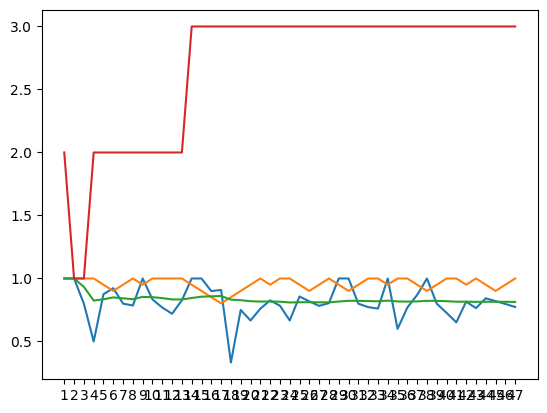

In [91]:
df = pd.DataFrame(test).T


import matplotlib.pyplot as plt
import numpy as np


plt.plot(df['pfree'])
plt.plot(df['epsilon'])
plt.plot(df['average_reward'])
plt.plot(df['k'])
# plt.plot(df['listen_period']/df['interval'])

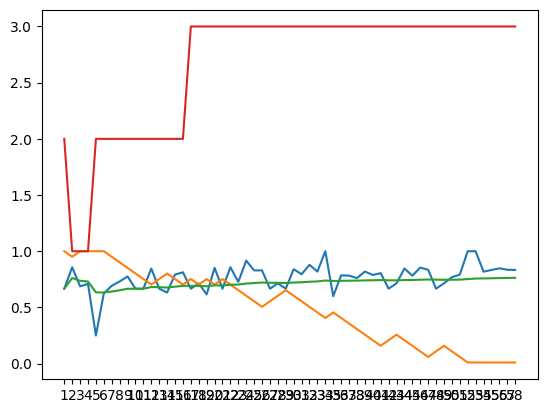

In [89]:
df = pd.DataFrame(test).T


import matplotlib.pyplot as plt
import numpy as np


plt.plot(df['pfree'])
plt.plot(df['epsilon'])
plt.plot(df['average_reward'])
plt.plot(df['k'])
# plt.plot(df['listen_period']/df['interval'])